# COVID-19 Deaths Evolution Comparison
### A fair comparison taking into account the population of a country and the starting date of deaths. 
Each curve represents the number of deaths per million in a country. The starting point is the date when the number is greater than 10. 

## Get the Data

### Select the countries to process

In [2]:
country_list = ['France', 'Italy', 'US', 'Spain', 'Sweden']

### Select the minimal count of deaths for the starting date 

In [3]:
min_count = 10

### Choose Data tools

In [4]:
import pandas as pnd

### Import Country Reference Data

In [5]:
src_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19"
csv_ref_file = src_url + "/1a68338bddea934490f772051121adad47bf543e/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
ref_filter_column = 'Country_Region'
ref_data = pnd.read_csv(csv_ref_file)
ref_data = ref_data[ref_data[ref_filter_column].isin(country_list)]
ref_data = ref_data[ref_data['Province_State'].isnull()]
ref_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
58,250,FR,FRA,250.0,NaN,NaN,NaN,France,46.227600,2.213700,France,65273512.0
81,380,IT,ITA,380.0,NaN,NaN,NaN,Italy,41.871940,12.567380,Italy,60461828.0
153,724,ES,ESP,724.0,NaN,NaN,NaN,Spain,40.463667,-3.749220,Spain,46754783.0
157,752,SE,SWE,752.0,NaN,NaN,NaN,Sweden,60.128161,18.643501,Sweden,10099270.0
265,840,US,USA,840.0,NaN,NaN,NaN,US,40.000000,-100.000000,US,329466283.0


### Import Daily Covid-19 Data

In [6]:
csv_daily_file = src_url + "/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
filter_column = 'Country/Region'
drop_columns = ['Province/State', 'Lat', 'Long']
data_in = pnd.read_csv(csv_daily_file)
data_less_columns = data_in.drop(drop_columns, axis=1)    
data_less_rows = data_less_columns[data_less_columns[filter_column].isin(country_list)]
data_aggregated = data_less_rows.groupby(filter_column).sum() 
data = data_aggregated.reset_index()
data.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,France,0,0,0,0,0,0,0,0,0,...,3532,4043,5398,6520,7574,8093,8926,10343,10887,12228
1,Italy,0,0,0,0,0,0,0,0,0,...,12428,13155,13915,14681,15362,15887,16523,17127,17669,18279
2,Spain,0,0,0,0,0,0,0,0,0,...,8464,9387,10348,11198,11947,12641,13341,14045,14792,15447
3,Sweden,0,0,0,0,0,0,0,0,0,...,180,239,308,358,373,401,477,591,687,793
4,US,0,0,0,0,0,0,0,0,0,...,3873,4757,5926,7087,8407,9619,10783,12722,14695,16478


### Transform Input Data
The original dataset has timeseries columns and 1 row per location. A different layout is easier to process: in each row, 1 column for the country, 1 for the date, 1 for the daily count.

In [8]:
data_per_capita = pnd.DataFrame()
data_percentage = pnd.DataFrame()
new_columns = ['country', 'date', 'nb_cases']
date_list = pnd.DataFrame(data_aggregated.columns)
for filter_value in country_list:
    ref_data_single_row = ref_data[ref_data[ref_filter_column] == filter_value]
    population = ref_data_single_row['Population'].values[0]
    country_data = data[data[filter_column] == filter_value]
    y_values = country_data.values[0,1:]
    bool_count_started = False
    quantum = 0
    for date, value in zip(range(y_values.size), y_values):
        rel_value = value / population * 1000000
        if bool_count_started:
            quantum = date - start_date
        elif rel_value >= min_count:
            start_date = date 
            bool_count_started = True
        data_per_capita = data_per_capita.append({
            new_columns[0]:filter_value,
            new_columns[1]:date, 
            new_columns[2]:value
            }, ignore_index=True)
        data_percentage = data_percentage.append({
            new_columns[0]:filter_value,
            new_columns[1]:quantum, 
            new_columns[2]:rel_value
            }, ignore_index=True)
data_per_capita.head()
data_percentage.head()

,country,date,nb_cases
0,France,0.0,0.0
1,France,0.0,0.0
2,France,0.0,0.0
3,France,0.0,0.0
4,France,0.0,0.0


### Display the graph

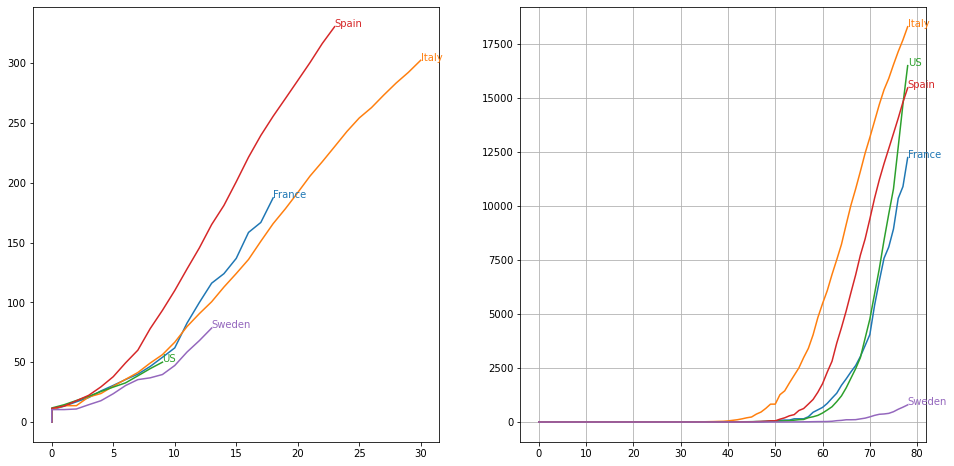

In [31]:
import matplotlib.pyplot as plt
fig, (graph1, graph2) = plt.subplots(1, 2, figsize=(16,8))
for country in country_list:
    graph_percentage = graph1.plot(data_percentage[data_percentage['country'] == country]['date'], 
        data_percentage[data_percentage['country'] == country]['nb_cases'], 
        label=country)
    graph_per_capita = graph2.plot(data_per_capita[data_per_capita['country'] == country]['date'], 
        data_per_capita[data_per_capita['country'] == country]['nb_cases'], 
        label=country)
    graph1.annotate(xy=[graph_percentage[0].get_data()[0][-1], graph_percentage[0].get_data()[1][-1]], s=country, color=graph_percentage[0].get_color())
    graph2.annotate(xy=[graph_per_capita[0].get_data()[0][-1], graph_per_capita[0].get_data()[1][-1]], s=country, color=graph_per_capita[0].get_color())
plt.grid()
plt.show()